In [2]:
import hopsy as hp
import numpy as np
import matplotlib.pyplot as plt

import time

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
POSITION = [0,1]
DIPOLE_MOMENT = 2

def flatten(items):
    return [item for sublist in items for item in sublist] if isinstance(items, list) else items.flatten()

class CanonicalEnsemble():
    """
        Canonical Ensemble with potentials for chains of magnetic dipoles, 
        taken from https://pubs.rsc.org/en/content/articlelanding/2020/NR/D0NR01646B#!divAbstract
    """
    def __init__(self, K_f = 2.5, r_f = 2, sigma = 1, H = 1, beta = 1, eps = 1):
        self.K_f = K_f
        self.r_f = r_f
        self.sigma = sigma
        self.r_cut = 2**(1/6) * sigma
        self.H = np.array([0, H])
        self.beta = beta
        self.eps = eps
        self.U_LJ_cut = 4 * self.eps * ((self.sigma / self.r_cut)**12 - (self.sigma / self.r_cut)**6)
        
    def compute_negative_log_likelihood(self, x):
        return self.hamiltonian(x)
    
    def hamiltonian(self, x):
        return self.beta * (self.fene_potential(x) + self.wca_potential(x) + self.zeeman_potential(x) + self.interparticle_potential(x))
        
    def fene_potential(self, x):
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        U = 0
        n = len(x)
        for i in range(n-1):
            r = np.linalg.norm(x[i][POSITION] - x[i+1][POSITION])
            U += (-self.K_f * self.r_f**2) * np.log(1 - (r / self.r_f)**2) / 2 if (r/self.r_f)**2 < 1 else np.inf

        return U

    def interparticle_potential(self, x):
        """
            Following (3) in https://pubs.rsc.org/en/content/articlelanding/2020/NR/D0NR01646B#!divAbstract
        """
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        U = 0
        n = len(x)
        for i in range(n):
            for j in range(i+1, n):
                r_ij = x[i][POSITION] - x[j][POSITION]
                r = np.linalg.norm(r_ij)
                
                mu_i = np.array([np.cos(x[i][DIPOLE_MOMENT]), np.sin(x[i][DIPOLE_MOMENT])])
                mu_j = np.array([np.cos(x[j][DIPOLE_MOMENT]), np.sin(x[j][DIPOLE_MOMENT])])
                
                U += np.dot(mu_i, mu_j) / np.linalg.norm(r)**3 - 3 * np.dot(mu_i, r_ij) * np.dot(mu_j, r_ij) / np.linalg.norm(r)**5 #if r != 0 else np.inf
        
        return U

    def wca_potential(self, x):
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        n = len(x)
        U = 0
        for i in range(n):
            for j in range(i+1, n):
                r = np.linalg.norm(x[i][POSITION] - x[j][POSITION])
                U += 0 if r > self.r_cut else 4 * self.eps * ((self.sigma / r)**12 - (self.sigma / r)**6) - self.U_LJ_cut

        return U

    def zeeman_potential(self, x):
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        n = len(x)
        U = 0
        for i in range(n):
            mu = np.array([np.cos(x[i,DIPOLE_MOMENT]), np.sin(x[i,DIPOLE_MOMENT])])
            U += -np.dot(mu, self.H)

        return U

    


In [4]:

ens = CanonicalEnsemble(sigma=1, r_f=2, beta=1)

def draw_state(x, ens, color='C0', alpha=1, fig=None, ax=None, xlim=None, ylim=None, no_particles=False):
    fig, ax = plt.subplots(1, 1, dpi=300) if fig is None and ax is None else (fig, ax)
    ax.set_aspect(1)
    x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
    n = len(x)

    if not no_particles:
        for i in range(n):
            particle = plt.Circle(x[i,POSITION], ens.sigma, clip_on=False, fill=False, color=color, alpha=alpha)
            ax.add_patch(particle)

            mu = np.array([np.cos(x[i,DIPOLE_MOMENT]), np.sin(x[i,DIPOLE_MOMENT])])
            ax.arrow(*(x[i,POSITION]-.8*ens.sigma*mu), *(2*.8*ens.sigma*mu), head_width=.5*ens.sigma, alpha=alpha, length_includes_head=True, color='black', zorder=10)

    for i in range(n-1):
        a = x[i,POSITION]
        b = x[i+1,POSITION]
        if np.linalg.norm(b - a) < ens.r_f:
            ax.plot([a[0], b[0]], [a[1], b[1]], color=color, alpha=alpha)
        else:
            ax.plot([a[0], b[0]], [a[1], b[1]], color='red', alpha=alpha)
            
    xlim = ax.get_xlim() if xlim is None else xlim
    ylim = ax.get_ylim() if ylim is None else ylim
    
    a_x, b_x = int(np.floor(xlim[0])), int(np.ceil(xlim[1]))
    a_y, b_y = int(np.floor(ylim[0])), int(np.ceil(ylim[1]))
    
    xx, yy = np.meshgrid(
        np.linspace(a_x, b_x, 2 * (b_x - a_x) + 1), 
        np.linspace(a_y, b_y, 2 * (b_y - a_y) + 1))
    
    ax.quiver(xx, yy, ens.H[0], ens.H[1], pivot='middle', color='gray', alpha=.5)
    ax.fill_between(xlim, [ylim[0], ylim[0]], [0, 0], color='gray', alpha=.1)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
        
    return fig, ax


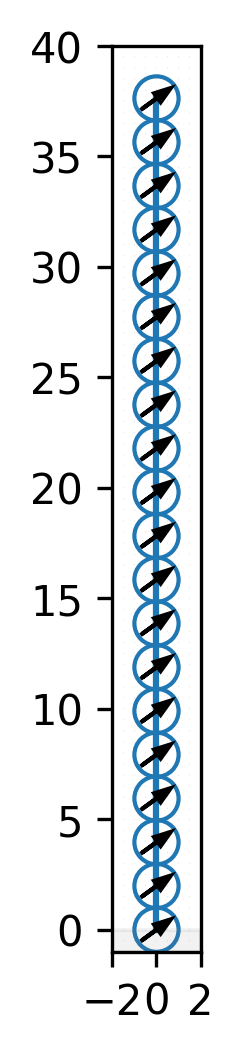

In [5]:
n = 20

c, d = 3, 3 # c ... number of constraints per state, d ... number of dimensions per state

A, b = np.zeros((c*n-1, d*n-2)), 1e-5*np.ones((c*n-1))

for i in range(n):
    if i > 0:
        A[c*i-1,d*i-1] = -1
    
    A[c*i,d*i] = 1
    A[c*i+1,d*i] = -1

    b[c*i] = 2*np.pi
    
ens = CanonicalEnsemble(sigma=1, r_f=2, beta=1)
problem = hp.Problem(A, b, ens)

starting_point = [[np.pi / 5]] + [[0, .99*ens.r_f*i, np.pi / 5] for i in range(1, n)]
draw_state(starting_point, ens, xlim=[-2, 2], ylim=[-1, 40])
plt.show()

In [6]:
m = 4

mcs = [hp.MarkovChain(problem, starting_point=flatten(starting_point)) for i in range(m)]

rngs = [hp.RandomNumberGenerator(0, i) for i in range(m)]

esjd = hp.ExpectedSquaredJumpDistanceTarget(mcs, n_test_samples=1000)
accrate = hp.AcceptanceRateTarget(mcs, n_test_samples=1000)

In [7]:
start = time.time()
method = hp.ThompsonSamplingTuning(lower_bound=1e0, upper_bound=1e4, grid_size=41, record_data=True)
esjd_stepsize, esjd_data = hp.tune(method, esjd, rngs)
print("elapsed:", time.time() - start)

start = time.time()
method = hp.ThompsonSamplingTuning(lower_bound=1e0, upper_bound=1e4, grid_size=41, record_data=True)
accrate_stepsize, accrate_data = hp.tune(method, accrate, rngs)
print("elapsed:", time.time() - start)


KeyboardInterrupt: 

In [ ]:
#print(esjd_data)

print(len(esjd_data))

for posterior in [esjd_data, accrate_data]:
    data = posterior[np.where(posterior[:,3] != 0)][:,3:]
    plt.scatter(data[:,0], data[:,1])
    plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='none')
    plt.plot(posterior[:,0], posterior[:,1])
    plt.show()

for mc in mcs: mc.proposal.stepsize = esjd_stepsize[0]

In [11]:
start = time.time()
accrate, states = hp.sample(mcs, rngs, 350, thinning=3000, n_threads=m)
print("elapsed:", time.time() - start)

KeyboardInterrupt: 

In [ ]:
print(accrate)
print("R-hat (mean, max):", np.format_float_positional(np.mean(hp.rhat(states)), precision=3, fractional=False), np.format_float_positional(np.max(hp.rhat(states)), precision=3, fractional=False))
#print("R-hat (mean, max): ", np.format_float_positional(np.mean(hp.rhat(states)), precision=3, fractional=False), np.format_float_positional(np.max(hp.rhat(states)), precision=3, fractional=False))

In [ ]:
fig, ax = None, None

for i in range(0, len(states[0]), 100000):
    fig, ax = draw_state(states[0,i], ens, fig=fig, ax=ax, alpha=.8, xlim=[-10, 10], ylim=[-1,20], no_particles=True)#, xlim=xlim, ylim=ylim)
    
plt.show()

In [8]:
def compute_mean_nn_distance(states):
    mean_nn_dist = []
    for chain in states:
        for state in chain:
            diff = np.diff(flatten(np.hstack([[0, 0], state])).reshape(-1, 3)[:,:2], axis=0)
            mean_nn_dist.append(np.mean(np.linalg.norm(diff, axis=1)))
            
    return np.mean(mean_nn_dist)
        
def compute_end_to_end_distance(states):
    Ree = []
    N = np.ceil(len(states[0,0]) / 3)
    for chain in states:
        for state in chain:
            mean_nn_dist = compute_mean_nn_distance([[state]])
            Ree.append(np.linalg.norm(flatten(state)[-3:-1]) / (mean_nn_dist * N))
            
    return Ree

Ree = compute_end_to_end_distance(states)

print(f"%f in [%f, %f]" % (np.mean(Ree), np.quantile(Ree, 0.05), np.quantile(Ree, 0.95)))

NameError: name 'states' is not defined

In [12]:
n = 20

c, d = 3, 3 # c ... number of constraints per state, d ... number of dimensions per state

A, b = np.zeros((c*n-1, d*n-2)), 1e-5*np.ones((c*n-1))

for i in range(n):
    if i > 0:
        A[c*i-1,d*i-1] = -1
    
    A[c*i,d*i] = 1
    A[c*i+1,d*i] = -1

    b[c*i] = 2*np.pi
    
Hs = [0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 4, 5, 6]

print(len(Hs))

problems = [hp.Problem(A, b, CanonicalEnsemble(sigma=1, r_f=2, beta=1, H=H)) for H in Hs]
starting_point = [[np.pi / 5]] + [[0, .99*ens.r_f*i, np.pi / 5] for i in range(1, n)]

n = 1000
m = 10

def tune(problem, starting_point):
    """
        returns tuned chains + rngs
    """
    mcs = [hp.MarkovChain(problem, starting_point=flatten(starting_point)) for i in range(m)]
    rngs = [hp.RandomNumberGenerator(0, i) for i in range(m)]

    esjd = hp.ExpectedSquaredJumpDistanceTarget(mcs, n_test_samples=n)

    elapsed = time.time()
    method = hp.ThompsonSamplingTuning(lower_bound=1e0, upper_bound=1e4, grid_size=41)
    stepsize, _ = hp.tune(method, esjd, rngs)
    elapsed = time.time() - elapsed
    
    for mc in mcs:
        mc.proposal.stepsize = stepsize
        
    return mcs, rngs


def sample(mc, rng):
    elapsed = time.time()
    accrate, states = hp.sample(mc, rng, 350, thinning=3*n, n_threads=1)
    elapsed = time.time() - elapsed

    return (elapsed, accrate), states


tuning_args = [(problem, starting_point) for problem in problems]

16


In [51]:
from multiprocessing import Pool

n_parallel = 60
with Pool(min(n_parallel, len(tuning_args))) as p:
    tuned_chains = p.starmap(tune, tuning_args)

In [ ]:
sampling_args = []
for mcs, rngs in tuned_chains:
#    sampling_args += [(mcs[i], rngs[i]) for i in range(m)]
    sampling_args += [(mcs[0], rngs[0])]
    
print(len(sampling_args))

In [15]:
with Pool(min(n_parallel, len(sampling_args))) as p:
    sampling_data = p.starmap(sample, sampling_args)

#sample(*sampling_args[0])

In [16]:
def f(_, states):
    Ree = compute_end_to_end_distance(states)
    return np.mean(Ree), np.quantile(Ree, 0.05), np.quantile(Ree, 0.95)

print(sampling_data[9][-1].shape)

(1, 350, 58)


In [17]:
with Pool(n_parallel) as p:
    results = p.starmap(f, sampling_data)

data = np.array(results).reshape(-1, 1)

(0.7939738612527919, 0.500730947031734, 0.949302329729314)

(0.0, 1.0)

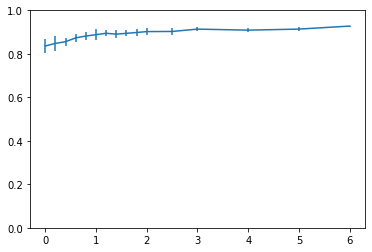

In [50]:
plt.errorbar(Hs, np.mean(data, axis=1), yerr=np.sqrt(np.var(data, axis=1)))
plt.ylim([0, 1])